In [1]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole
from src.utils import load_known_rxns
import pandas as pd

IPythonConsole.drawOptions.addAtomIndices=True

# akg

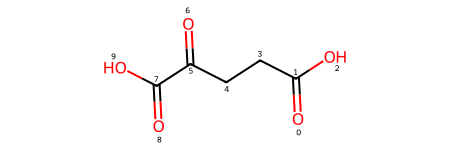

In [22]:
# Test mol

smi = "O=C(O)CCC(=O)C(=O)O"
mol = Chem.MolFromSmiles(smi)
mol

# One split RCGNN min ops multiclass results

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from chemprop.data import build_dataloader
from chemprop import models
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_known_rxns
from src.utils import construct_sparse_adj_mat
from src import data
from src.featurizer import RCVNReactionMolGraphFeaturizer, MultiHotAtomFeaturizer, MultiHotBondFeaturizer
from sklearn.model_selection import train_test_split
import numpy as np
from lightning import pytorch as pl
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [14]:

df = pd.read_csv("./artifacts/model_evals/gnn/rc_gnn_v0_sprhea_sp_folded_pt_rxns_x_min_ops_100_epochs_seed_1234/version_1/metrics.csv")
df.head()

,batch_averaged_test/ce,epoch,step,train_loss
0,NaN,0,49,1734.673584
1,NaN,1,99,1109.704834
2,NaN,1,149,814.335144
3,NaN,2,199,647.530273
4,NaN,2,249,455.589600


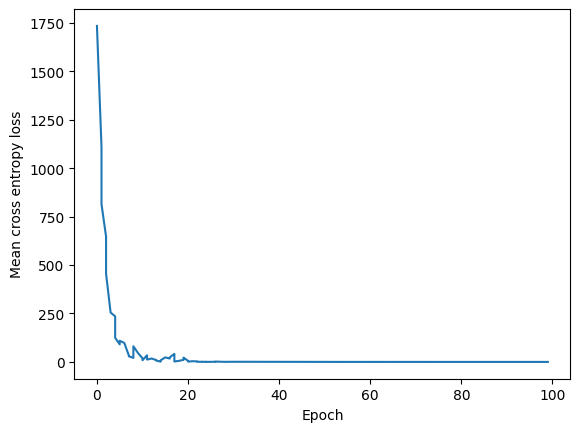

In [15]:
plt.plot(df.loc[:,"epoch"], df.loc[:,"train_loss"])
plt.xlabel('Epoch')
plt.ylabel('Mean cross entropy loss')
plt.show()

In [7]:
# Load trained model
path = "./artifacts/model_evals/gnn/rc_gnn_last_agg_sprhea_sp_folded_pt_rxns_x_min_ops_100_epochs_seed_1234/version_0/checkpoints/epoch=99-step=8400.ckpt"
mpnn = models.MPNN.load_from_file(path, map_location=torch.device('cpu'))

dataset = 'sprhea'
toc = 'sp_folded_pt_rxns_x_min_ops'
krs = load_known_rxns("./data/sprhea/known_rxns_240310_v2_folded_protein_transcript.json")
seed = 1234

# Load data
adj, idx_sample, idx_feature = construct_sparse_adj_mat(dataset, toc)
feature_idx = {v:k for k,v in idx_feature.items()}
X = [krs[k] for k in list(krs.keys())]
min_rule_labels = ["_".join(sorted(elt['min_rules'])) for elt in X] # Rule names
min_rule_idxs = np.array([feature_idx[elt] for elt in min_rule_labels]) # Indices in adj mat
n_samples = len(X)
n_classes = len(feature_idx)
y = min_rule_idxs.reshape(-1,1) # Class index encoding

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

# Init featurizer
featurizer = RCVNReactionMolGraphFeaturizer(
    atom_featurizer=MultiHotAtomFeaturizer.no_stereo(),
    bond_featurizer=MultiHotBondFeaturizer()
)

# Construct dataset
datapoints_train = [data.RxnRCDatapoint.from_smi(kr, y=y_train[i]) for i, kr in enumerate(X_train)]
datapoints_test = [data.RxnRCDatapoint.from_smi(kr, y=y_test[i]) for i, kr in enumerate(X_test)]

dataset_train = data.RxnRCDataset(datapoints_train, featurizer=featurizer)
dataset_test = data.RxnRCDataset(datapoints_test, featurizer=featurizer)

data_loader_train = build_dataloader(dataset_train, shuffle=False)
data_loader_test = build_dataloader(dataset_test, shuffle=False)


Constructing sprhea:sp_folded_pt_rxns_x_min_ops sparse adjacency matrix


In [8]:
with torch.inference_mode():
    trainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        accelerator="cpu",
        devices=1
    )
    test_preds = trainer.predict(mpnn, data_loader_test)

/home/spn1560/.conda/envs/hiec/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/spn1560/.conda/envs/hiec/lib/python3.11/site-p ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/spn1560/.conda/envs/hiec/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to

Predicting: |          | 0/? [00:00<?, ?it/s]

In [9]:
test_preds = np.concatenate(test_preds, axis=0).reshape(-1, n_classes)
y_pred = np.argmax(test_preds, axis=1).reshape(-1,)
y_true = dataset_test.Y.reshape(-1,)

In [11]:

scorers = {
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'),
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro'),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro'),
    'accuracy': accuracy_score
}

scores = {}

for k, scorer in scorers.items():
    scores[k] = scorer(y_true, y_pred)

print(scores)

{'f1': 0.6940097756755753, 'precision': 0.69464994040852, 'recall': 0.7138142425586514, 'accuracy': 0.9177001127395716}


/home/spn1560/.conda/envs/hiec/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spn1560/.conda/envs/hiec/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
foo = next(iter(data_loader_train))

In [46]:
last_idxs = torch.tensor([torch.argwhere(foo.bmg.batch == i)[-1,0] for i in range(64)])
foo.bmg.V[last_idxs, :].shape

torch.Size([64, 67])

# Experiment w/ getting all atom mapping

In [38]:
%load_ext autoreload
%autoreload 2

from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole
from src.utils import load_known_rxns
from src.atom_mapping import *
import pandas as pd

IPythonConsole.drawOptions.addAtomIndices=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
i = 25
krs = load_known_rxns("./data/sprhea/known_rxns_240310_v2_folded_protein_transcript.json")
k = list(krs.keys())[i]
smarts = krs[k]['smarts']
rcs = krs[k]['rcs']
min_rules = krs[k]['min_rules']

min_ops = pd.read_csv("./data/sprhea/minimal1224_all_uniprot.tsv", sep='\t')
min_ops.set_index("Name", inplace=True)
min_ops.head()

,Reactants,SMARTS,Products,Comments
Name,,,,
rule0001,Any;Any,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;Any,A0A060PLD9;A0A0P0YNP7;A0A0P9RZM9;A1XCQ0;A3E242...
rule0002,Any;NAD_CoF,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,NADH_CoF;Any,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
rule0003,NADH_CoF;Any,[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,Any;NAD_CoF,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
rule0004,Any;NADH_CoF;O2,[#6:1].[#6:2]1=[#6:3]-[#7:4]-[#6:5]=[#6:6]-[#6...,Any;NAD_CoF;WATER,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...
rule0005,Any;NAD_CoF;WATER,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,Any;NADH_CoF;O2,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...


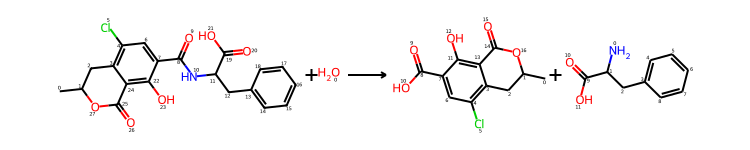

In [40]:
# k = list(krs.keys())[i]
# smarts = krs[k]['smarts']
# i +=1
AllChem.ReactionFromSmarts(smarts, useSmiles=True)

In [41]:
rule = min_ops.loc[min_rules[0], 'SMARTS']
operator = Chem.rdChemReactions.ReactionFromSmarts(rule)
reactants = [Chem.MolFromSmiles(elt) for elt in smarts.split(">>")[0].split('.')]
products = [Chem.MolFromSmiles(elt) for elt in smarts.split(">>")[1].split('.')]

am_smarts = atom_map_rxn(smarts, rule, rcs[0], rcs[1], ((0, 1),))

(1, 0) [1, 3]
(0,) [2]


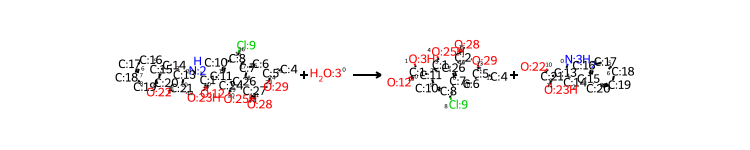

In [42]:
AllChem.ReactionFromSmarts(am_smarts, useSmiles=True)

In [43]:
print(am_smarts.split(">>")[1].split("."))

['[C:1]([OH:3])([c:11]1[c:1]([OH:25])[c:26]2[c:7]([c:8]([Cl:9])[cH:10]1)[CH2:6][CH:5]([CH3:4])[O:29][C:2]2=[O:28])=[O:12]', '[NH2:3][CH:13]([CH2:14][c:15]1[cH:16][cH:17][cH:18][cH:19][cH:20]1)[C:21](=[O:22])[OH:23]']


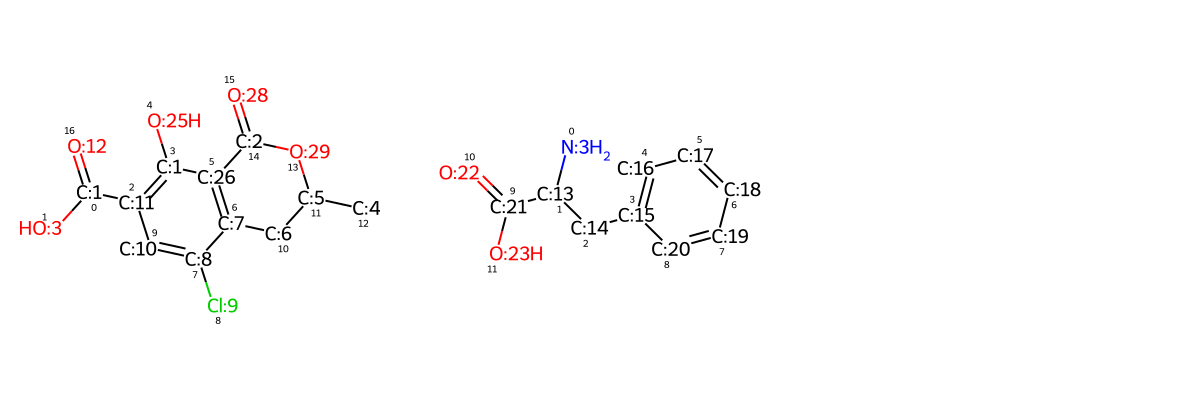

In [44]:
output_am = [Chem.MolFromSmiles(Chem.CanonSmiles(elt)) for elt in am_smarts.split(">>")[1].split(".")]
Draw.MolsToGridImage(output_am, subImgSize=(400, 400))

In [27]:
print(smarts.split(">>")[1].split('.'))

['CC1Cc2c(Cl)cc(C(=O)O)c(O)c2C(=O)O1', 'NC(Cc1ccccc1)C(=O)O']


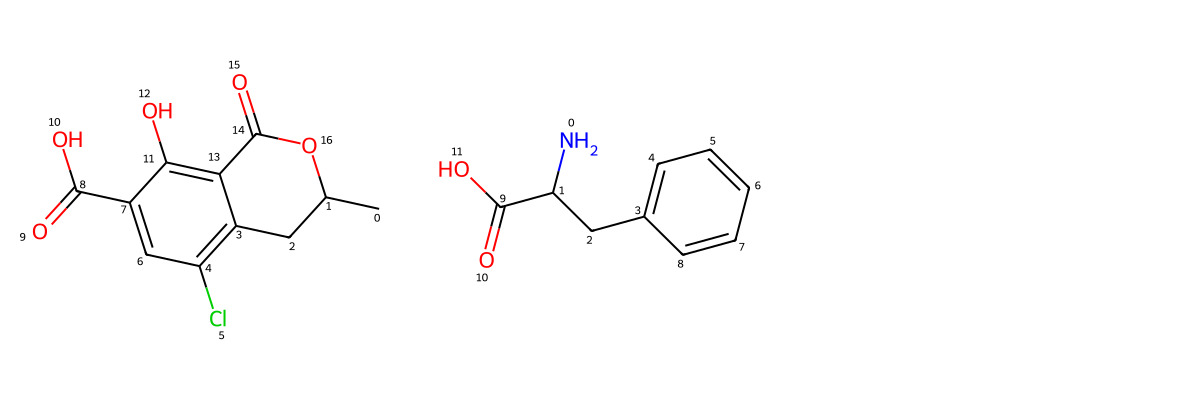

In [14]:
Draw.MolsToGridImage(products, subImgSize=(400, 400))

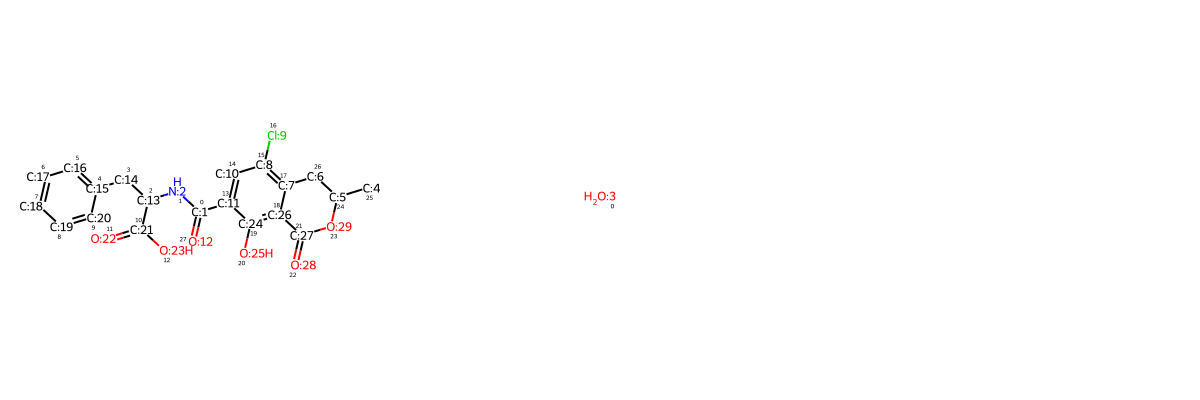

In [45]:
input_am = [Chem.MolFromSmiles(Chem.CanonSmiles(elt)) for elt in am_smarts.split(">>")[0].split(".")]
Draw.MolsToGridImage(input_am, subImgSize=(400, 400))

In [99]:
rcs

[[[8, 10], [0]], [[8, 10], [0]]]

In [96]:
rule

'[#6:1]-[#7:2].[#8:3]>>[#6:1]-[#8:3].[#7:2]'

In [1]:
import pandas as pd
import numpy as np
from src.utils import load_embed

In [2]:
import pandas as pd

# Sample DataFrame
data = {
    'Category': ['A', 'B', 'A', 'B', 'A', 'C', 'C'],
    'Subcategory': ['X', 'Y', 'X', 'Y', 'Z', 'X', 'X'],
    'Value': [10, 20, 30, 40, 50, 60, 70],
    'Value2': [10, 20, 30, 40, 50, 400, 700]
}

df = pd.DataFrame(data)

# Grouping by 'Category' and 'Subcategory'
grouped = df.groupby(['Category', 'Subcategory'])

# Iterate over the groups and print them
for (category, subcategory), group in grouped:
    print(f"Category: {category}, Subcategory: {subcategory}")
    print(group)
    print(type(group))
    print()


Category: A, Subcategory: X
  Category Subcategory  Value  Value2
0        A           X     10      10
2        A           X     30      30
<class 'pandas.core.frame.DataFrame'>

Category: A, Subcategory: Z
  Category Subcategory  Value  Value2
4        A           Z     50      50
<class 'pandas.core.frame.DataFrame'>

Category: B, Subcategory: Y
  Category Subcategory  Value  Value2
1        B           Y     20      20
3        B           Y     40      40
<class 'pandas.core.frame.DataFrame'>

Category: C, Subcategory: X
  Category Subcategory  Value  Value2
5        C           X     60     400
6        C           X     70     700
<class 'pandas.core.frame.DataFrame'>



In [3]:
group.loc[:, ['Value', 'Value2']].to_numpy()

array([[ 60, 400],
       [ 70, 700]])

In [4]:
for elt in df.loc[:,'Value']:
    print(elt)

10
20
30
40
50
60
70


In [11]:
d = 10
tp = np.dtype([('sample_embed', np.float32, (d,)), ('feature', str), ('y', int)])
data = np.zeros(2, dtype=tp)
data['sample_embed']= [np.arange(d), np.arange(d, d*2)]
data['feature'] = ['foo', 'bar']
data['y'] = [0, 1]
data['sample_embed'], data['y'].shape

(array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.]], dtype=float32),
 (2,))

In [12]:
data['feature']

array(['', ''], dtype='<U0')

In [16]:
for row in data:
    print(row['sample_embed'])

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]


In [3]:
data_dir = "/projects/p30041/spn1560/hiec/data"
scratch_dir = "/scratch/spn1560"
ds_name = 'sprhea'
sample_embed_type = 'esm'
sample_name = 'Q0WSX8'
test_embed = load_embed(f"{data_dir}/{ds_name}/{sample_embed_type}/{sample_name}.pt", embed_key=33)[1].numpy()
test_embed.shape

(1280,)

In [7]:
foo = np.array(1)
bar = np.array(0)
np.array([foo, bar]).shape


(2,)

# Dict learning. Ensure trainability and loadability from checkpointability

In [1]:
from src.model import MPNNDimRed
from src.nn import LinDimRed, AttentionAggregation, BondMessagePassingDict
from chemprop.nn import MeanAggregation, BondMessagePassing, BinaryClassificationFFN, Aggregation
import torch

In [2]:
d_prot = 50
d_h_mpnn = 20
mp = BondMessagePassingDict()
agg = AttentionAggregation(input_dim=d_h_mpnn)
pred_head = BinaryClassificationFFN()


model = MPNNDimRed(
        reduce_X_d=LinDimRed(d_in=d_prot, d_out=d_h_mpnn),
        message_passing=mp,
        agg=agg,
        predictor=pred_head,
    )

In [3]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: message_passing.W_i.weight | Size: torch.Size([300, 86]) | Values : tensor([[-0.0061, -0.0986, -0.1009, -0.0911,  0.0976,  0.0725, -0.0262,  0.0054,
          0.0279, -0.1050, -0.0440,  0.0204,  0.0699, -0.0898, -0.0438, -0.0875,
         -0.0336, -0.0893,  0.0016, -0.0477, -0.0038, -0.1027,  0.0965, -0.0544,
          0.0406,  0.1040,  0.0372,  0.0330,  0.0772,  0.0856,  0.0794, -0.0626,
         -0.0786, -0.0585,  0.0180,  0.0562,  0.0644, -0.0123,  0.0272, -0.0889,
         -0.0965,  0.0042, -0.0819, -0.0414, -0.0041, -0.0656, -0.0114,  0.0827,
         -0.0015, -0.0870, -0.0524, -0.0258, -0.0642, -0.0967, -0.1039, -0.0256,
          0.0115, -0.0506,  0.0394,  0.0465,  0.1041,  0.0676, -0.0589,  0.1067,
         -0.0977, -0.0959,  0.0306, -0.0252, -0.0704, -0.0101, -0.1066, -0.0460,
          0.1053, -0.0219,  0.0134,  0.0378, -0.0212, -0.0846,  0.0975,  0.0086,
         -0.0765, -0.0849, -0.0774, -0.0385, -0.0091, -0.0040],
        [-0.0620, -0.0100,  0.0767,  0.0465,  0.042

In [ ]:
path = "/home/spn1560/hiec/data/new/new_80.clstr"

def parse_clusters(file_path):
    clusters = {}
    current_cluster = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith(">Cluster"):
                # Extract cluster number from the line
                cluster_number = int(line.split()[1])
                current_cluster = []
                clusters[cluster_number] = current_cluster
            elif current_cluster is not None:
                current_cluster.append(line)

    return clusters

# Example usage:
file_path = path  # Replace with your file path
clusters_dict = parse_clusters(file_path)

# Print the clusters dictionary
for cluster_num, lines in clusters_dict.items():
    print(f"Cluster {cluster_num}:")
    for line in lines:
        print(line)

# Accessing specific clusters:
# lines_of_cluster_41 = clusters_dict[41]


: 